## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [51]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [52]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [53]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [54]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [55]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [56]:
#finding the number of times new_page and treatment doesn't line up, where the landing page will be "old_page" or group
# will be "control"
df.query( 'group == "treatment" and landing_page == "old_page"').shape[0] + df.query( 'group == "control" and landing_page == "new_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


no missing values in all columns as non-null count for all columns equals total number of entries

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [58]:
df.query( 'group == "control" and landing_page == "new_page"')

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
490,808613,2017-01-10 21:44:01.292755,control,new_page,0
846,637639,2017-01-11 23:09:52.682329,control,new_page,1
850,793580,2017-01-08 03:25:33.723712,control,new_page,1
...,...,...,...,...,...
293894,741581,2017-01-09 20:49:03.391764,control,new_page,0
293996,942612,2017-01-08 13:52:28.182648,control,new_page,0
294200,928506,2017-01-13 21:32:10.491309,control,new_page,0
294253,886135,2017-01-06 12:49:20.509403,control,new_page,0


In [59]:
# index1 for rows where group = treatment and landing_page = old_page
# index2 for rows where group = control and landing_page = new_page
index1 = df.query( 'group == "treatment" and landing_page == "old_page"').index
index2 = df.query( 'group == "control" and landing_page == "new_page"').index
indx = index1.append(index2)
df2 = df.drop(indx, axis=0)

In [60]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [61]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [62]:
# using value_counts with descending order to pick the repeated user_id 
df2['user_id'].value_counts().sort_values(ascending=False).head(1)

773192    2
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [63]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [64]:
# Using drop_duplicates to remove the second row of the user_id 773192
df2 = df2.drop_duplicates(subset='user_id',keep = 'first')

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [65]:
# the mean is the sum of values / number of values, in this cases of zeroes and ones
# it represents the probability of convresion
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [66]:
# we use only the control group dataset then we find the probability requested
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [67]:
# we use only the treatment group dataset then we find the probability requested
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [68]:
# We use the value_counts function with normalize = True to find the fractions of each group
# hence their probability 
df2['group'].value_counts(normalize=True)

treatment    0.500062
control      0.499938
Name: group, dtype: float64

the probability that an individual receives a new page is 0.500062

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**there's no sufficient evidence to say that the new treatment page leads to more conversion as the mean for the new page is actually slightly lower than the mean of the old page and the two means are very close to the dataset mean while the dataset is equally split. a hypothesis test is needed to be certain that these values aren't out of sheer coincedence and the new page conversion actually equals or worse the old page conversion**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**1. The null hypothesis: the conversion rate of the new page equals or lower than the old page conversion rate, that is, the difference between them equals or lower than zero:** <br>
**P_new - P_old <= 0** 
<br>
**2. The alternative hypothesis: the conversion rate of the new page is higher than the old page conversion rate, that is, the difference between them is higher than zero:** <br>
**P_new - P_old > 0** <br>
* Where alpha is 0.05

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [69]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [70]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [71]:
n_new = df2.landing_page.value_counts().head(1)[0]
n_new

145310

d. What is $n_{old}$?

In [72]:
n_old = df2.landing_page.value_counts().tail(1)[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [73]:
new_page_converted = np.random.choice([0,1],size = n_new,  p = [p_new, (1-p_new)])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [74]:
old_page_converted = np.random.choice([0,1],size = n_old, p = [p_old, (1-p_old)])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [75]:
new_page_converted.mean() - old_page_converted.mean()

0.0011581876003589064

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [76]:
p_diffs = []

new_converted_sim = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_sim = np.random.binomial(n_old, p_old, 10000)/n_old
# appending the obtained averages in a list of averages
p_diffs = new_converted_sim - old_converted_sim

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0, 0.5, 'Count of values')

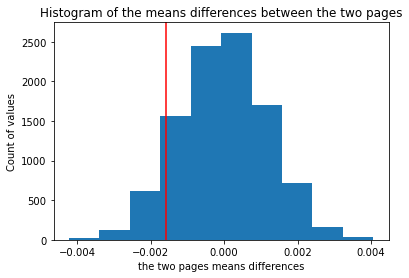

In [77]:
from turtle import color
plt.hist(p_diffs)
# plotting a vertical line that represents the observed mean in the dataset
plt.axvline(df2[df2['landing_page'] == 'new_page']['converted'].mean() - df2[df2['landing_page'] == 'old_page']['converted'].mean(), color = 'red')
plt.title('Histogram of the means differences between the two pages')
plt.xlabel('the two pages means differences')
plt.ylabel('Count of values')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [78]:
# computing the actual observed proportion in the dataset
act_mean = df2[df2['landing_page'] == 'new_page']['converted'].mean() - df2[df2['landing_page'] == 'old_page']['converted'].mean()
# calculating the proportion of values that are higher or equal than the observed mean
#summing the true outputs and dividing by the total number of p_diffs to obtain the required proportion
(np.array(p_diffs) >= np.array(act_mean)).sum()/len(p_diffs)

0.9047

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**the value calculated above represents the P-value which is the probability of the null hypothesis being true. this value is higher than alpha value (Type I error rate: rejecting the null hypothesis while it's actually true) assigned for the test (0.05). This means that we fail to reject the null hypothesis and there's a no evidence that the new page conversion rate is higher than the old page conversion rate**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [79]:
import statsmodels.api as sm
# first we calculate the number of successful trials for both pages (that is, conversion = 1)
convert_old = df2[df2['landing_page'] == 'old_page']['converted'].sum()
convert_new = df2[df2['landing_page'] == 'new_page']['converted'].sum()
# secondly we calculate the total number of trials
n_old = df2[df2['landing_page'] == 'old_page']['converted'].shape[0]
n_new = df2[df2['landing_page'] == 'new_page']['converted'].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [93]:
from statsmodels.stats.proportion import proportions_ztest 
# using the buit-in function, we input the number of successful trials, count of all trials and the hypothesed difference (zero)
# we use the parameter alternative 'larger' as larger means H1: p_old <p_new 
# we use prop_var = False as the variance of the proportion estimate is calculated based on the sample proportion.
stat, pval =sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old], value = 0, alternative='larger', prop_var = False)
print('The P-value is',pval.round(3),'for the z-score of',stat.round(3))

The P-value is 0.905 for the z-score of -1.311


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The computed value of p-value and z-score means that there's a high probability for the null hypothesis to be true (around 0.9). we can't reject the null hypothesis which means we fail to prove that the new page conversion rate is higher than the old page which agrees with our findings in parts j. and .k in conclusions and p-value approximately**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression which is used to classify outputs to 0s and 1s based on their probability from 0 to 1**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [81]:
# creating dummy variables for the dataset
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [82]:
#defining our output data
y = df2['converted']
#defining our input data (the ab_pag coloumn)
x1 = df2['ab_page']
#adding an intercept using add_constant
x = sm.add_constant(x1)
reg_log = sm.Logit(y,x)
results = reg_log.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


c:\Users\ahmed\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [83]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-10-11 02:32 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
const        -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The null hypothesis associated with the regression model is that the parameter coefficient β equals zero**
**meaning the ab_page (page type) parameter is insignificant (where H0 = P_new - P_old = 0) with the alternative hypothesis  (where H1 = P_new - P_old != 0)** <br>
**So, the P_value represents the probability that the ab_page parameter coefficient equals ZERO which is a two tailed t-test** <br>
**While the null hypothesis for our previous AB test was that H0 = P_new - P_old <= 0 with the alternative hypothesis as H1 = P_new - P_old > 0 which represents a one tailed t-test** <br>
**the P_value represents the probability that the new page conversion rate equals or lower than the old page conversion rate** <br>

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

* **The model parameter ab_page p_value is higher than 0.05 which means that for our only explantory variable we can't neither conclude it affects our dependant variable (conversion) nor it's useful in predicting whether or not a user converts** <br>
* **day of the week maybe a good explanatory variable to be considered by using the timestamp column.** <br>
* **However, adding more and more variables may affect the model ability to predict negatively as some insignificant variables may confuse our model. Also, adding more variables may cause multi-colinearity if we weren't too careful**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [84]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [85]:
df_new.head()

,country,timestamp,group,landing_page,converted,control,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1


In [86]:
### Create the necessary dummy variables
df_new[['CA','UK','US']]=pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,control,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0,1,0


In [87]:
### Fit Your Linear Model And Obtain the Results
y = df_new['converted']
x1 = df_new[['ab_page','UK','US']]
x = sm.add_constant(x1)
reg_log = sm.Logit(y,x)
results = reg_log.fit()
results.summary2()

c:\Users\ahmed\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-10-11 02:32 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -2.0300     0.0266   -76.2488   0.0000   -2.0822   -1.9778
ab_page   -0.0149     0.0114    -1.3069   0.1912   -0.0374    0.0075
UK         0.0506     0.0284     1.7835   0.0745   -0.0050    0.1063
US         0.0408     0.0269     1.5161   0.1295   -0.0119    0.0934
==================================================================

"""

**Again, our parameters coefficients for countries variables are very close to zero (odds near 1) with p_values higher than 0.05 meaning that we fail to conclude that these new parameters affect our dependant variable (conversion)**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [88]:
# Creating and adding each interaction parameter for each country
df_new['US_interaction'] = df_new['ab_page'] * df_new['US']
df_new['UK_interaction'] = df_new['ab_page'] * df_new['UK']
df_new['CA_interaction'] = df_new['ab_page'] * df_new['CA']

In [89]:
df_new.head()

,country,timestamp,group,landing_page,converted,control,ab_page,CA,UK,US,US_interaction,UK_interaction,CA_interaction
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,0,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0,1,0,0,1,0


In [90]:
### Fit Your Linear Model And Obtain the Results
# ab_page parameter wasn't in our model to avoid multi-colinearity
y = df_new['converted']
x1 = df_new[['ab_page','US','UK','US_interaction','UK_interaction']]
x = sm.add_constant(x1)
reg_log = sm.Logit(y,x)
results = reg_log.fit()
results.summary2()

c:\Users\ahmed\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-10-11 02:32 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
const             -2.0040   0.0364 -55.0077 0.0000 -2.0754 -1.9326
ab_page           -0.0674   0.0520  -1.2967 0.1947 -0.1694  0.0345
US                 0.0175   0.0377   0.4652 0.6418 -0.0563  0.0914
UK                 0.0118   0.0398   0.2957 0.7674 -0.0663  0.0899
US_interaction     0.0469   0.0538   0.8718 0.3833 -0.0585  0.1523
UK_interaction     0.0783   0.0568   1.3783 0.1681 -0.0330  0.1896
==================================================================

"""

In [91]:
# calculating our parameters' odds
np.exp(results.params)

const             0.134794
ab_page           0.934776
US                1.017682
UK                1.011854
US_interaction    1.048001
UK_interaction    1.081428
dtype: float64

**UK and USA interaction parameters have odds very close to 1 and p_values over our 0.05 
threshold meaning we can't conclude these explantory variables affects our dependent value.**

<a id='conclusions'></a>
## Conclusions
**In conclusion, We fail to reject the null hypothesis which states that the new page have a conversion rate higher the the old page. Using logistic regression also agrees with our findings as the page type parameter's coeficient (ab_page) have a probability of being zero (insignificant) higher than our alpha 0.05 with confidence intervals very close to zero. The new page seems to not affect our conversion rate significantly with various parameters also (country, countries interactions). with confidence intervals for most parameters very close to zero It would not be practical to consider the new page in question and it would be better to shift focus to developing another new page that affects the conversion rate of users significantly.**

**References**
1. statsmodel.org: statsmodels.stats.proportion.proportions_ztest
https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html